In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io 
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, glob, cv2

# packages needed for making a dataset: 
from torch.utils.data import DataLoader
from torchvision import transforms

from diffuser_utils import *
import dataset as ds
import models.spectral_model as sm
#import models.machinelearning_forward as fm

from datetime import date, datetime

import sys
sys.path.append("..")

from models.unet import Unet
import models.unet3d as unet3d


import csv

os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0" #choose the number of gpu that's free. It goes from 0-3

device = 'cuda:0'

In [2]:
import spectral_diffusercam_utils.helper_functions as helper

loaded_mat = scipy.io.loadmat('../SpectralDiffuserCam/SpectralDiffuserCam/Python/SampleData/calibration.mat')
img = plt.imread('../SpectralDiffuserCam/SpectralDiffuserCam/Python/SampleData/meas_thordog.png')
mask, psf, img = helper.preprocess(loaded_mat['mask'], loaded_mat['psf'], img)
mask = mask[:,:,0:-1]

In [3]:
psf_np = psf

In [4]:
def fft_psf(h):
    h_complex = pad_zeros_torch(forward_model,torch.complex(h,torch.zeros_like(h)))
    H = torch.fft.fft2(torch.fft.ifftshift(h_complex)).unsqueeze(1)
    return H
def fft_im(im):
    xc = torch.complex(im, torch.zeros_like(im))  
    Xi = torch.fft.fft2(xc)    
    return Xi
def tt(x):
    return torch.tensor(x, dtype = torch.float32, device = device)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os, glob, cv2
from diffuser_utils import *

class Forward_Model(torch.nn.Module):
    # Model initialization 
    def __init__(self, mask,               # mask: response matrix for the spectral filter array
                 num_ims = 2,              # number of blurred images to simulate
                 w_init = None,            # initialization for the blur kernels e.g., w_init = [.01, 0.01]
                 cuda_device = 0,          # cuda device parameter 
                 blur_type = 'symmetric',  # symmetric or asymmetric blur kernel 
                 optimize_blur = False):   # choose whether to learn the best blur or not (warning, not stable)
        super(Forward_Model, self).__init__()
        
        self.cuda_device = cuda_device
        self.blur_type  = blur_type
       
    
         ## Initialize constants
        self.DIMS0 = mask.shape[0]  # Image Dimensions
        self.DIMS1 = mask.shape[1]  # Image Dimensions
        self.PAD_SIZE0 = int((self.DIMS0))     # Pad size
        self.PAD_SIZE1 = int((self.DIMS1))     # Pad size
        
        self.num_ims = num_ims
  
        if w_init is None: #if no blur specified, use default
            if self.blur_type == 'symmetric':
                w_init = np.linspace(.002, .065, num_ims)
            else:
                w_init = np.linspace(.002, .1, num_ims)
                w_init =  np.repeat(np.array(w_init)[np.newaxis], self.num_ims, axis = 0).T
                w_init[:,1] *=.5
             
        print('optimize blur', optimize_blur)
        if self.blur_type == 'symmetric':
            #self.w_init =  np.repeat(np.array(w_init[0])[np.newaxis], self.num_ims, axis = 0)
            self.w_init = w_init
            self.w_blur = torch.nn.Parameter(torch.tensor(self.w_init, dtype = torch.float32, 
                                                          device = self.cuda_device,
                                                         requires_grad = optimize_blur))
        else:
            self.w_init =  w_init
            self.w_blur = torch.nn.Parameter(torch.tensor(self.w_init, dtype = torch.float32, 
                                                          device = self.cuda_device,
                                                         requires_grad = optimize_blur))

        # set up grid 
        x=np.linspace(-1,1,self.DIMS1); 
        y=np.linspace(-1,1,self.DIMS0); 
        X,Y=np.meshgrid(x,y)
        
        self.X = torch.tensor(X, dtype=torch.float32, device=self.cuda_device)
        self.Y = torch.tensor(Y, dtype=torch.float32, device=self.cuda_device)
        
        self.mask = np.transpose(mask, (2,0,1))
        self.mask_var = torch.tensor(self.mask, dtype=torch.float32, device=self.cuda_device).unsqueeze(0)
        self.psf = np.empty((num_ims, self.DIMS0, self.DIMS1))
        
    
    def make_psfs(self, ):
        
        psfs = []
        for i in range(0,self.num_ims):
            if self.blur_type == 'symmetric':
                psf= torch.exp(-((self.X/self.w_blur[i])**2+(self.Y/self.w_blur[i])**2))
            else:
                psf= torch.exp(-((self.X/self.w_blur[i,0])**2+(self.Y/self.w_blur[i,1])**2))
            
            #psf = psf/torch.max(psf)
            psfs.append(psf)
        
        return torch.stack(psfs, 0)
    def Hfor(self):
        H = fft_psf(self.psfs)
        X = self.Xi
        out = torch.fft.ifft2(H*X).real
        output = forward_model.mask_var * crop_forward(forward_model,  out)
        output = torch.sum(output, 2)
        return output
    
    def Hadj(self, sim_meas):
        Hconj = torch.conj(fft_psf(self.psfs))
        sm = pad_zeros_torch(self, sim_meas.unsqueeze(2) * self.mask_var)
        SM = fft_im(sm)
        adj_meas = torch.fft.ifft2(Hconj*SM).real
        return adj_meas
    
    # forward call for the model
    def forward(self, in_image):
        self.Xi = fft_im(in_image).unsqueeze(0)
        self.psfs = self.make_psfs()
        final_output = self.Hfor()
        return final_output

In [6]:
# define fwd model
num_images = 1
num_inputs_simult = 2
blur_type = 'symmetric'
optimize_blur = False
forward_model = Forward_Model(mask, num_ims = num_inputs_simult, blur_type = blur_type, cuda_device = device)

optimize blur False


In [13]:
x = np.random.randn(2, 64, mask.shape[0]*2, mask.shape[1]*2)
x = np.zeros((2, 64, mask.shape[0]*2, mask.shape[1]*2))
x[:,10:20, mask.shape[0], mask.shape[1]]=1

y = np.random.randn(1, 2, mask.shape[0], mask.shape[1])

forward_model.Xi = fft_im(tt(x)).unsqueeze(0)
forward_model.psfs = forward_model.make_psfs()

y_tilda = forward_model.Hfor().detach().cpu().numpy()
x_tilda2 = forward_model.Hadj(tt(y_tilda)).detach().cpu().numpy()
x_tilda = forward_model.Hadj(tt(y)).detach().cpu().numpy()


print((y.ravel()).dot(y_tilda.ravel()))
print((x.ravel()).dot(x_tilda.ravel()))


39.55045538219187
39.55044862655268


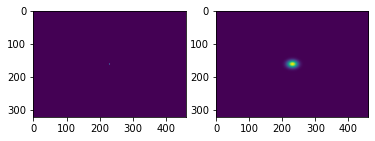

In [14]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(forward_model.psfs[0].detach().cpu().numpy())
ax[1].imshow(forward_model.psfs[1].detach().cpu().numpy())

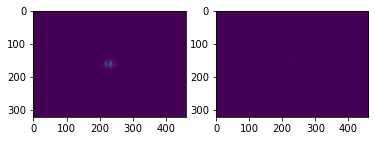

In [9]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(y_tilda[0,0])
ax[1].imshow(y_tilda[0,1])

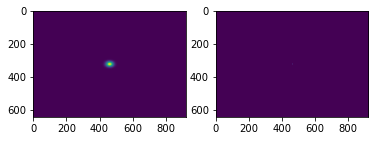

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(x_tilda2[0,0, 20])
ax[1].imshow(x_tilda2[0,1, 20])

In [9]:
def Hfor(im, psf):
    H = fft_psf(psf)
    X = fft_im(im)
    out = torch.fft.ifft2(H*X,  dim = (-2, -1)).real
    output = forward_model.mask_var * crop_forward(forward_model,  out)
    output = torch.sum(output, 1)
    return output

def Hadj(sim_meas, psf):
    Hconj = torch.conj(fft_psf(psf))
    sm = pad_zeros_torch(forward_model, sim_meas * forward_model.mask_var)
    SM = fft_im(sm)
    adj_meas = torch.fft.ifft2(Hconj*SM).real
    return adj_meas

In [ ]:
x = np.random.randn(64, mask.shape[0]*2, mask.shape[1]*2)
#x = np.zeros((64, mask.shape[0]*2, mask.shape[1]*2))
#x[30,mask.shape[0],mask.shape[1]]=1
y = np.random.randn(mask.shape[0], mask.shape[1])

y_tilda = Hfor(tt(x), tt(psf)).detach().cpu().numpy()#[0,1]
x_tilda = Hadj(tt(y), tt(psf)).detach().cpu().numpy()


print((y.ravel()).dot(y_tilda.ravel()))
print((x.ravel()).dot(x_tilda.ravel()))

In [ ]:
.shape

In [ ]:
x_tilda.shape

In [ ]:
y_tilda.shape

In [ ]:
y.shape